In [1]:
import sklearn as sk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import os

# Define the path to the subfolder containing the CSV files
csv_folder_path = '../saved_csvs'

# Get a list of all CSV files in the subfolder
csv_files = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')]

# Create a dictionary of dataframes
dataframes = {f[:-4]: pd.read_csv(os.path.join(csv_folder_path, f)) for f in csv_files}



/tmp/ipykernel_45598/2265674051.py:11: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = {f[:-4]: pd.read_csv(os.path.join(csv_folder_path, f)) for f in csv_files}


In [3]:
for name, df in dataframes.items():
    print(f"CSV File: {name}")
    print(f"Number of rows: {len(df)}")
    print("Column names:", list(df.columns))
    print()  # Add a blank line for better readability

CSV File: taxi_zones
Number of rows: 263
Column names: ['OBJECTID', 'zone', 'borough', 'Shape_Leng', 'Shape_Area', 'the_geom']

CSV File: legally_operating_business
Number of rows: 281413
Column names: ['Unnamed: 0', 'DCA License Number', 'License Type', 'License Expiration Date', 'License Creation Date', 'Industry', 'Business Name', 'Address Building', 'Address ZIP', 'Address Borough', 'BIN', 'Latitude', 'Longitude']

CSV File: taxi_trip
Number of rows: 24648499
Column names: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'PULocationID', 'DOLocationID', 'passenger_count']

CSV File: subway_surfers
Number of rows: 58306773
Column names: ['transit_timestamp', 'transit_mode', 'borough', 'ridership', 'latitude', 'longitude', 'Georeference']

CSV File: mta_stations
Number of rows: 493
Column names: ['Station ID', 'Line', 'Stop Name', 'Borough', 'GTFS Latitude', 'GTFS Longitude']

CSV File: arrests
Number of rows: 63621
Column names: ['Unnamed: 0', 'ARREST_KEY', 'ARREST_DATE', 'ARREST_PR

In [4]:
zipcode = dataframes["nyc_zipcodes_data"]
geo_data = pd.read_csv("nyc_geo.csv")
print(geo_data.shape,geo_data.isna().sum())
poly = geo_data["geometry"]
geo_data.head() 
neighborhoods = pd.read_csv("../data_to_be_cleaned/2020_Neighborhood_Tabulation_Areas__NTAs__-_Tabular_20240610.csv")
business = dataframes["legally_operating_business"]

(262, 2) ZCTA5CE20    0
geometry     0
dtype: int64


In [5]:
business = business.dropna(subset=['Address ZIP'])

In [6]:
from shapely.geometry import Point
arrests = dataframes["arrests"]
print(arrests.columns)
def make_point(row):
    return Point(row['Longitude'], row['Latitude'])

arrests['geometry'] = arrests.apply(make_point, axis=1)

print(arrests.dtypes)
arrests.isna().sum()

Index(['Unnamed: 0', 'ARREST_KEY', 'ARREST_DATE', 'ARREST_PRECINCT',
       'ARREST_BORO', 'Latitude', 'Longitude'],
      dtype='object')
Unnamed: 0           int64
ARREST_KEY           int64
ARREST_DATE         object
ARREST_PRECINCT      int64
ARREST_BORO         object
Latitude           float64
Longitude          float64
geometry            object
dtype: object


Unnamed: 0         0
ARREST_KEY         0
ARREST_DATE        0
ARREST_PRECINCT    0
ARREST_BORO        0
Latitude           0
Longitude          0
geometry           0
dtype: int64

In [7]:
print(zipcode.dtypes)
zipcode.isna().sum()


zipcode         int64
city           object
state          object
lat           float64
lng           float64
population    float64
density       float64
land_area     float64
water_area    float64
dtype: object


zipcode        0
city           0
state          0
lat            0
lng            0
population    72
density       72
land_area     72
water_area    72
dtype: int64

In [8]:
print(business.dtypes)
# Count non-integer rows
non_int_count = business['Address ZIP'].apply(lambda x: not str(x).isdigit()).sum()
print(f"Number of non-integer rows: {non_int_count}")

# Drop non-integer rows
business = business[business['Address ZIP'].apply(lambda x: str(x).isdigit())]

# Convert the column to integers
business["Address ZIP"] = business["Address ZIP"].astype(int)
business.isna().sum()

Unnamed: 0                   int64
DCA License Number          object
License Type                object
License Expiration Date     object
License Creation Date       object
Industry                    object
Business Name               object
Address Building            object
Address ZIP                 object
Address Borough             object
BIN                         object
Latitude                   float64
Longitude                  float64
dtype: object
Number of non-integer rows: 80


Unnamed: 0                      0
DCA License Number              0
License Type                    0
License Expiration Date     21071
License Creation Date           0
Industry                        0
Business Name                  41
Address Building            94713
Address ZIP                     0
Address Borough             95124
BIN                        116208
Latitude                   104029
Longitude                  104029
dtype: int64

In [9]:
from shapely.geometry import Point

mta_stations = dataframes["mta_stations"].head(1000)
subway = dataframes["subway_surfers"].head(100000)
print(mta_stations.columns)
print(subway.columns)
unique_longitude_count = subway['longitude'].nunique()
unique_latitude_count = subway['latitude'].nunique()
# subway['Point'] = subway.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
print(f"Unique Longitude values: {unique_longitude_count}")
print(f"Unique Latitude values: {unique_latitude_count}")
geo = subway['Georeference'].nunique()
print(f"Unique geo values: {geo}")

subway.head()

Index(['Station ID', 'Line', 'Stop Name', 'Borough', 'GTFS Latitude',
       'GTFS Longitude'],
      dtype='object')
Index(['transit_timestamp', 'transit_mode', 'borough', 'ridership', 'latitude',
       'longitude', 'Georeference'],
      dtype='object')
Unique Longitude values: 463
Unique Latitude values: 462
Unique geo values: 479


,transit_timestamp,transit_mode,borough,ridership,latitude,longitude,Georeference
0,2023-06-06 03:00:00,subway,Manhattan,5,40.738228,-73.996208,POINT (-73.99620819091797 40.73822784423828)
1,2023-01-17 18:00:00,subway,Manhattan,524,40.738228,-73.996208,POINT (-73.99620819091797 40.73822784423828)
2,2023-08-23 12:00:00,subway,Manhattan,218,40.738228,-73.996208,POINT (-73.99620819091797 40.73822784423828)
3,2023-09-15 19:00:00,subway,Manhattan,47,40.738228,-73.996210,POINT (-73.99621 40.738228)
4,2023-10-11 12:00:00,subway,Manhattan,210,40.738228,-73.996210,POINT (-73.99621 40.738228)


In [10]:

subway['transit_timestamp'] = pd.to_datetime(subway['transit_timestamp'])

subway['pickup_month'] = subway['transit_timestamp'].dt.month
subway['pickup_year'] = subway['transit_timestamp'].dt.year
subway['pickup_hour'] = subway['transit_timestamp'].dt.hour


unique_zones = subway['Georeference'].unique()


zone_hourly_counts = {}

for zone in unique_zones:
    zone_hourly_counts[zone] = []
    for hour in range(24):
        filtered_trips = subway[
            (subway['pickup_hour'] == hour) &
            (subway['Georeference'] == zone)
        ]
        trip_count = filtered_trips.shape[0]
        
        # Append the count to the dictionary
        zone_hourly_counts[zone].append(trip_count)

# Convert the dictionary to a DataFrame for better readability
zone_hourly_df = pd.DataFrame(zone_hourly_counts, index=range(24))

point_counts = zone_hourly_df.transpose()
point_counts['total counts'] = point_counts.sum(axis=1)

# Normalizing the trip counts
normalized_counts = (point_counts - point_counts.min(axis=0)) / (point_counts.max(axis=0) - point_counts.min(axis=0))


/tmp/ipykernel_45598/67438423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway['transit_timestamp'] = pd.to_datetime(subway['transit_timestamp'])
/tmp/ipykernel_45598/67438423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway['pickup_month'] = subway['transit_timestamp'].dt.month
/tmp/ipykernel_45598/67438423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [11]:
print(normalized_counts.head())
point_counts = normalized_counts.copy()

                                                     0         1         2  \
POINT (-73.99620819091797 40.73822784423828)  0.773196  0.749472  0.734709   
POINT (-73.99621 40.738228)                   0.027706  0.028149  0.027523   
POINT (-74.0002 40.737827)                    0.005799  0.007741  0.006116   
POINT (-73.99678802490234 40.73782730102539)  0.019330  0.024631  0.047401   
POINT (-74.00019836425781 40.73782730102539)  0.199742  0.109782  0.119266   

                                                     3         4         5  \
POINT (-73.99620819091797 40.73822784423828)  0.694844  0.664587  0.769082   
POINT (-73.99621 40.738228)                   0.029586  0.026521  0.032342   
POINT (-74.0002 40.737827)                    0.005917  0.004680  0.007762   
POINT (-73.99678802490234 40.73782730102539)  0.075232  0.061622  0.038810   
POINT (-74.00019836425781 40.73782730102539)  0.221471  0.207488  0.166235   

                                                     6        

In [12]:
print(type(point_counts))
point_counts

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,total counts
POINT (-73.99620819091797 40.73822784423828),0.773196,0.749472,0.734709,0.694844,0.664587,0.769082,0.845210,0.899944,0.921970,0.918356,...,0.958065,0.996769,0.967091,0.964770,0.952040,0.956643,0.842800,0.907077,0.843967,0.891727
POINT (-73.99621 40.738228),0.027706,0.028149,0.027523,0.029586,0.026521,0.032342,0.036799,0.032979,0.034864,0.041644,...,0.032258,0.034464,0.036093,0.037398,0.039140,0.031128,0.032702,0.024000,0.027164,0.033165
POINT (-74.0002 40.737827),0.005799,0.007741,0.006116,0.005917,0.004680,0.007762,0.000000,0.000000,0.001107,0.000000,...,0.000000,0.000539,0.000000,0.000000,0.000000,0.000000,0.002869,0.001846,0.000000,0.001623
POINT (-73.99678802490234 40.73782730102539),0.019330,0.024631,0.047401,0.075232,0.061622,0.038810,0.029790,0.018446,0.014388,0.014795,...,0.009677,0.006462,0.006900,0.005420,0.010474,0.009450,0.024670,0.019077,0.013266,0.019865
POINT (-74.00019836425781 40.73782730102539),0.199742,0.109782,0.119266,0.221471,0.207488,0.166235,0.150117,0.106205,0.123409,0.076712,...,0.062366,0.127087,0.037155,0.048238,0.085998,0.101167,0.138841,0.204923,0.127606,0.110289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POINT (-73.94527 40.747845),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000548,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
POINT (-74.00019 40.71953),0.000000,0.000000,0.000765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
POINT (-73.987495 40.75529),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
POINT (-74.00758 40.710373),0.000000,0.000000,0.000765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
arrests.columns

Index(['Unnamed: 0', 'ARREST_KEY', 'ARREST_DATE', 'ARREST_PRECINCT',
       'ARREST_BORO', 'Latitude', 'Longitude', 'geometry'],
      dtype='object')

In [14]:
arrests['geometry'].nunique()   

17879

In [15]:

arrests['ARREST_DATE'] = pd.to_datetime(arrests['ARREST_DATE'])

arrests['pickup_month'] = arrests['ARREST_DATE'].dt.month
arrests['pickup_year'] = arrests['ARREST_DATE'].dt.year
arrests['pickup_hour'] = arrests['ARREST_DATE'].dt.hour


unique_zones = arrests['geometry'].unique()


zone_hourly_counts = {}

for zone in unique_zones:
    zone_hourly_counts[zone] = []
    for hour in range(24):
        filtered_trips = arrests[
            (arrests['pickup_hour'] == hour) &
            (arrests['geometry'] == zone)
        ]
        trip_count = filtered_trips.shape[0]
        
        # Append the count to the dictionary
        zone_hourly_counts[zone].append(trip_count)

# Convert the dictionary to a DataFrame for better readability
zone_hourly_df = pd.DataFrame(zone_hourly_counts, index=range(24))

point_counts_arrests = zone_hourly_df.transpose()
point_counts_arrests['total counts'] = point_counts_arrests.sum(axis=1)

# Normalizing the trip counts
normalized_counts = (point_counts_arrests - point_counts_arrests.min(axis=0)) / (point_counts_arrests.max(axis=0) - point_counts_arrests.min(axis=0))


KeyboardInterrupt: 

In [16]:
from uszipcode import SearchEngine
from shapely.geometry import Point
from shapely import wkt

# Initialize the search engine
search = SearchEngine()

# Ensure the index is of type string
point_counts.index = point_counts.index.astype(str)

# Create a new column 'points' by converting the index to geometrical points
point_counts['points'] = point_counts.index
point_counts['points'] = point_counts['points'].apply(wkt.loads)

# Print columns and data types to verify
print(point_counts.columns)
print(point_counts.dtypes)

# Define the function to get the zip code
def gimme_zips(point):
    zippy = search.by_coordinates(point.y, point.x, radius=10, returns=1)
    if zippy:
        return zippy[0].zipcode
   # or you can use a default value like '00000'

# Apply the function to the 'points' column to get the zip codes
point_counts['zip'] = point_counts['points'].apply(gimme_zips)

# Print the resulting DataFrame
print(point_counts)


/home/eamonn-walsh/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Index([             0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,             10,             11,
                   12,             13,             14,             15,
                   16,             17,             18,             19,
                   20,             21,             22,             23,
       'total counts',       'points'],
      dtype='object')
0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
10              float64
11              float64
12              float64
13              float64
14              float64
15              float64
16              float64
17              float64
18              float64
19              float64
20              float64
21      

In [17]:
# point_counts["zip"] = point_counts["zip"].astype(int)
print(point_counts.dtypes)
print(zipcode.dtypes)
point_counts["zip"].isna().sum()   
point_counts["zip"] = point_counts["zip"].astype(int)
new_column_names = {col: f"hour {col}" for col in point_counts.columns if isinstance(col, int)}
point_counts.rename(columns=new_column_names, inplace=True)

print(point_counts)
print(point_counts.dtypes)


0               float64
1               float64
2               float64
3               float64
4               float64
5               float64
6               float64
7               float64
8               float64
9               float64
10              float64
11              float64
12              float64
13              float64
14              float64
15              float64
16              float64
17              float64
18              float64
19              float64
20              float64
21              float64
22              float64
23              float64
total counts    float64
points           object
zip              object
dtype: object
zipcode         int64
city           object
state          object
lat           float64
lng           float64
population    float64
density       float64
land_area     float64
water_area    float64
dtype: object
                                                hour 0    hour 1    hour 2  \
POINT (-73.99620819091797 40.73822784423828)  0.

In [18]:
print(zipcode.shape)
print(point_counts.shape)

point_counts = point_counts.drop('points', axis=1)
aggregated_point_counts = point_counts.groupby('zip').agg('sum').reset_index()
zip_trip = pd.merge(zipcode,aggregated_point_counts, left_on='zipcode', right_on='zip', how='left')
print(zip_trip)

(302, 9)
(479, 27)
     zipcode          city state    lat    lng  population  density  \
0      10002      New York    NY  40.71 -73.99     81410.0  92573.0   
1      10041      New York    NY  40.71 -73.99         NaN      NaN   
2      10045      New York    NY  40.71 -73.99         NaN      NaN   
3      10055      New York    NY  40.71 -73.99         NaN      NaN   
4      10060      New York    NY  40.71 -73.99         NaN      NaN   
..       ...           ...   ...    ...    ...         ...      ...   
297    10466         Bronx    NY  40.89 -73.85     67813.0  33601.0   
298    10475         Bronx    NY  40.88 -73.82     40931.0  23753.0   
299    10464         Bronx    NY  40.87 -73.80      4534.0   1295.0   
300     7663  Saddle Brook    NJ  40.90 -74.09     13659.0   5080.0   
301     7011       Clifton    NJ  40.88 -74.14     39710.0  11940.0   

     land_area  water_area      zip  ...   hour 15   hour 16   hour 17  \
0         0.88        0.00  10002.0  ...  0.003226  0.

In [19]:
merged_df = pd.merge(business, zip_trip, left_on='Address ZIP', right_on='zipcode', how='left')

# Display the first few rows of the merged dataframe to verify the join
print(merged_df)

        Unnamed: 0 DCA License Number License Type License Expiration Date  \
0                0        0967332-DCA     Business              02/28/2017   
1                1        2103411-DCA   Individual              03/31/2024   
2                2        2060087-DCA   Individual              03/31/2024   
3                4        2057801-DCA   Individual              02/28/2019   
4                5        1415974-DCA   Individual              10/31/2012   
...            ...                ...          ...                     ...   
280457      281408        1244857-DCA     Business              04/30/2024   
280458      281409        1339416-DCA     Business              11/01/2023   
280459      281410        0966535-DCA     Business              04/30/2024   
280460      281411        1413476-DCA     Business              04/30/2024   
280461      281412        1418198-DCA     Business              04/30/2024   

       License Creation Date                      Industry  \
0

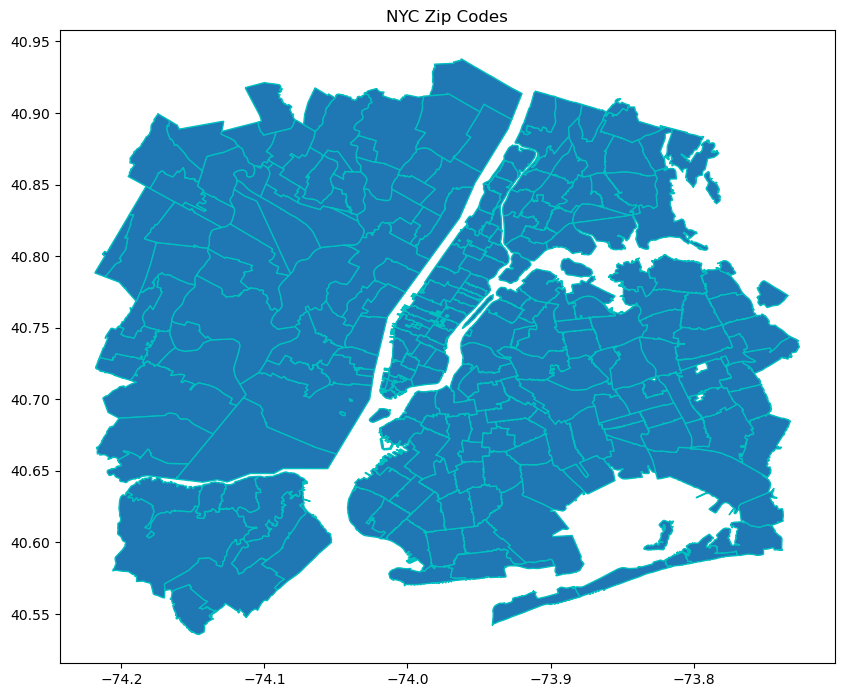

In [20]:

# Convert the dataframe to a GeoDataFrame
geo_data['geometry'] = gpd.GeoSeries.from_wkt(geo_data['geometry'])
geo_gdf = gpd.GeoDataFrame(geo_data, geometry='geometry')

# Plot the zip codes
fig, ax = plt.subplots(figsize=(10, 10))
geo_gdf.plot(ax=ax, edgecolor='c')

# Add a title and show the plot
plt.title("NYC Zip Codes")
plt.show()

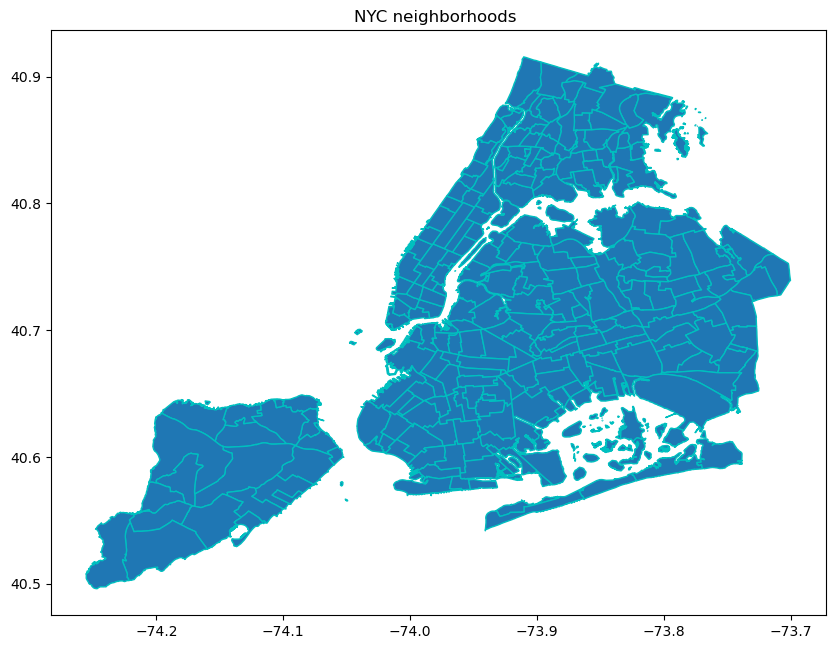

In [21]:
from shapely import wkt

# Assuming geo_data is your DataFrame containing the geometry column
neighborhoods['the_geom'] = neighborhoods['the_geom'].apply(wkt.loads)
neighborhoods = gpd.GeoDataFrame(neighborhoods, geometry='the_geom')

# Plotting the data
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.plot(ax=ax, edgecolor='c')

# Add a title and show the plot
plt.title("NYC neighborhoods ")
plt.show()

In [22]:
merged_df.columns

Index(['Unnamed: 0', 'DCA License Number', 'License Type',
       'License Expiration Date', 'License Creation Date', 'Industry',
       'Business Name', 'Address Building', 'Address ZIP', 'Address Borough',
       'BIN', 'Latitude', 'Longitude', 'zipcode', 'city', 'state', 'lat',
       'lng', 'population', 'density', 'land_area', 'water_area', 'zip',
       'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6',
       'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12',
       'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18',
       'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23', 'total counts'],
      dtype='object')

In [23]:
merged_df.dtypes

Unnamed: 0                   int64
DCA License Number          object
License Type                object
License Expiration Date     object
License Creation Date       object
Industry                    object
Business Name               object
Address Building            object
Address ZIP                  int64
Address Borough             object
BIN                         object
Latitude                   float64
Longitude                  float64
zipcode                    float64
city                        object
state                       object
lat                        float64
lng                        float64
population                 float64
density                    float64
land_area                  float64
water_area                 float64
zip                        float64
hour 0                     float64
hour 1                     float64
hour 2                     float64
hour 3                     float64
hour 4                     float64
hour 5              

In [24]:
print(merged_df.isna().sum())

Unnamed: 0                      0
DCA License Number              0
License Type                    0
License Expiration Date     21071
License Creation Date           0
Industry                        0
Business Name                  41
Address Building            94713
Address ZIP                     0
Address Borough             95124
BIN                        116208
Latitude                   104029
Longitude                  104029
zipcode                     42641
city                        42641
state                       42641
lat                         42641
lng                         42641
population                  43827
density                     43827
land_area                   43827
water_area                  43827
zip                         98396
hour 0                      98396
hour 1                      98396
hour 2                      98396
hour 3                      98396
hour 4                      98396
hour 5                      98396
hour 6        

In [25]:
no_na = merged_df.dropna(subset=['lat','lng','hour 0'])


In [26]:
print(no_na.isna().sum())

Unnamed: 0                     0
DCA License Number             0
License Type                   0
License Expiration Date    10459
License Creation Date          0
Industry                       0
Business Name                 21
Address Building           50627
Address ZIP                    0
Address Borough            50394
BIN                        55266
Latitude                   50750
Longitude                  50750
zipcode                        0
city                           0
state                          0
lat                            0
lng                            0
population                   150
density                      150
land_area                    150
water_area                   150
zip                            0
hour 0                         0
hour 1                         0
hour 2                         0
hour 3                         0
hour 4                         0
hour 5                         0
hour 6                         0
hour 7    

In [39]:
no_na['zipcode'].nunique()

116

In [27]:
no_na['Industry'].unique()

array(['Sightseeing Guide', 'Tow Truck Driver', 'Ticket Seller',
       'Pedicab Driver', 'Home Improvement Salesperson', 'Garage',
       'Tobacco Retail Dealer', 'Laundries', 'Sidewalk Cafe',
       'Secondhand Dealer - General', 'Electronic & Appliance Service',
       'Secondhand Dealer - Auto', 'General Vendor', 'Employment Agency',
       'Home Improvement Contractor', 'Newsstand', 'Electronics Store',
       'Stoop Line Stand', 'Tow Truck Company',
       'Electronic Cigarette Dealer', 'Parking Lot', 'Laundry',
       'Locksmith', 'Dealer In Products', 'Horse Drawn Driver',
       'Garage and Parking Lot', 'Process Server Individual',
       'Laundry Jobber', 'Construction Labor Provider', 'Pawnbroker',
       'Pedicab Business', 'Car Wash', 'Special Sale',
       'Third Party Food Delivery', 'Process Serving Agency',
       'Pool or Billiard Room', 'Catering Establishment',
       'Scrap Metal Processor', 'Amusement Device Portable',
       'Tow Truck Exemption', 'Bingo Game Op

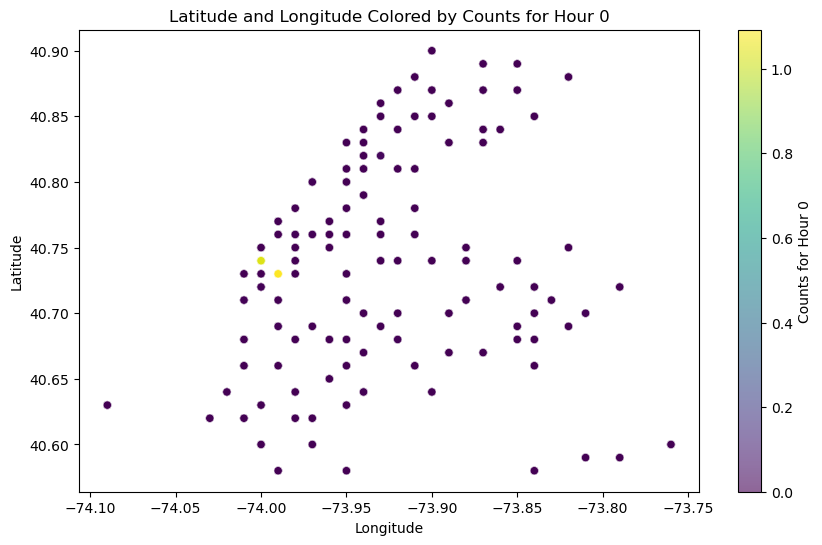

In [28]:
count_hour = 0

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(no_na['lng'], no_na['lat'], c=no_na['hour 0'], cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)

# Adding color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Counts for Hour {}'.format(count_hour))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Latitude and Longitude Colored by Counts for Hour {}'.format(count_hour))

# Show plot
plt.show()

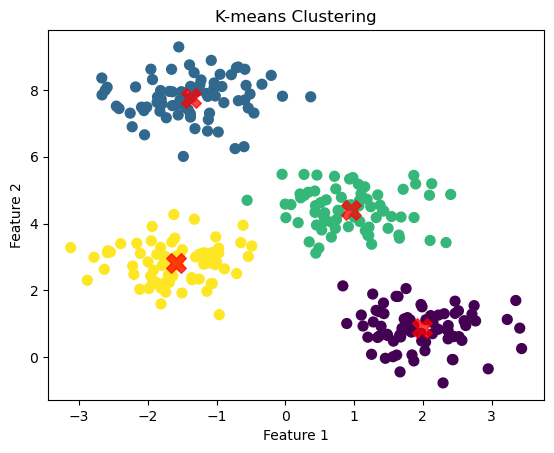

In [29]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
# Create a synthetic dataset
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plotting the clusters
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [30]:
no_na['zip'].nunique()
no_na.to_csv("inputs.csv")

Silhouette Score: 0.999991168425131


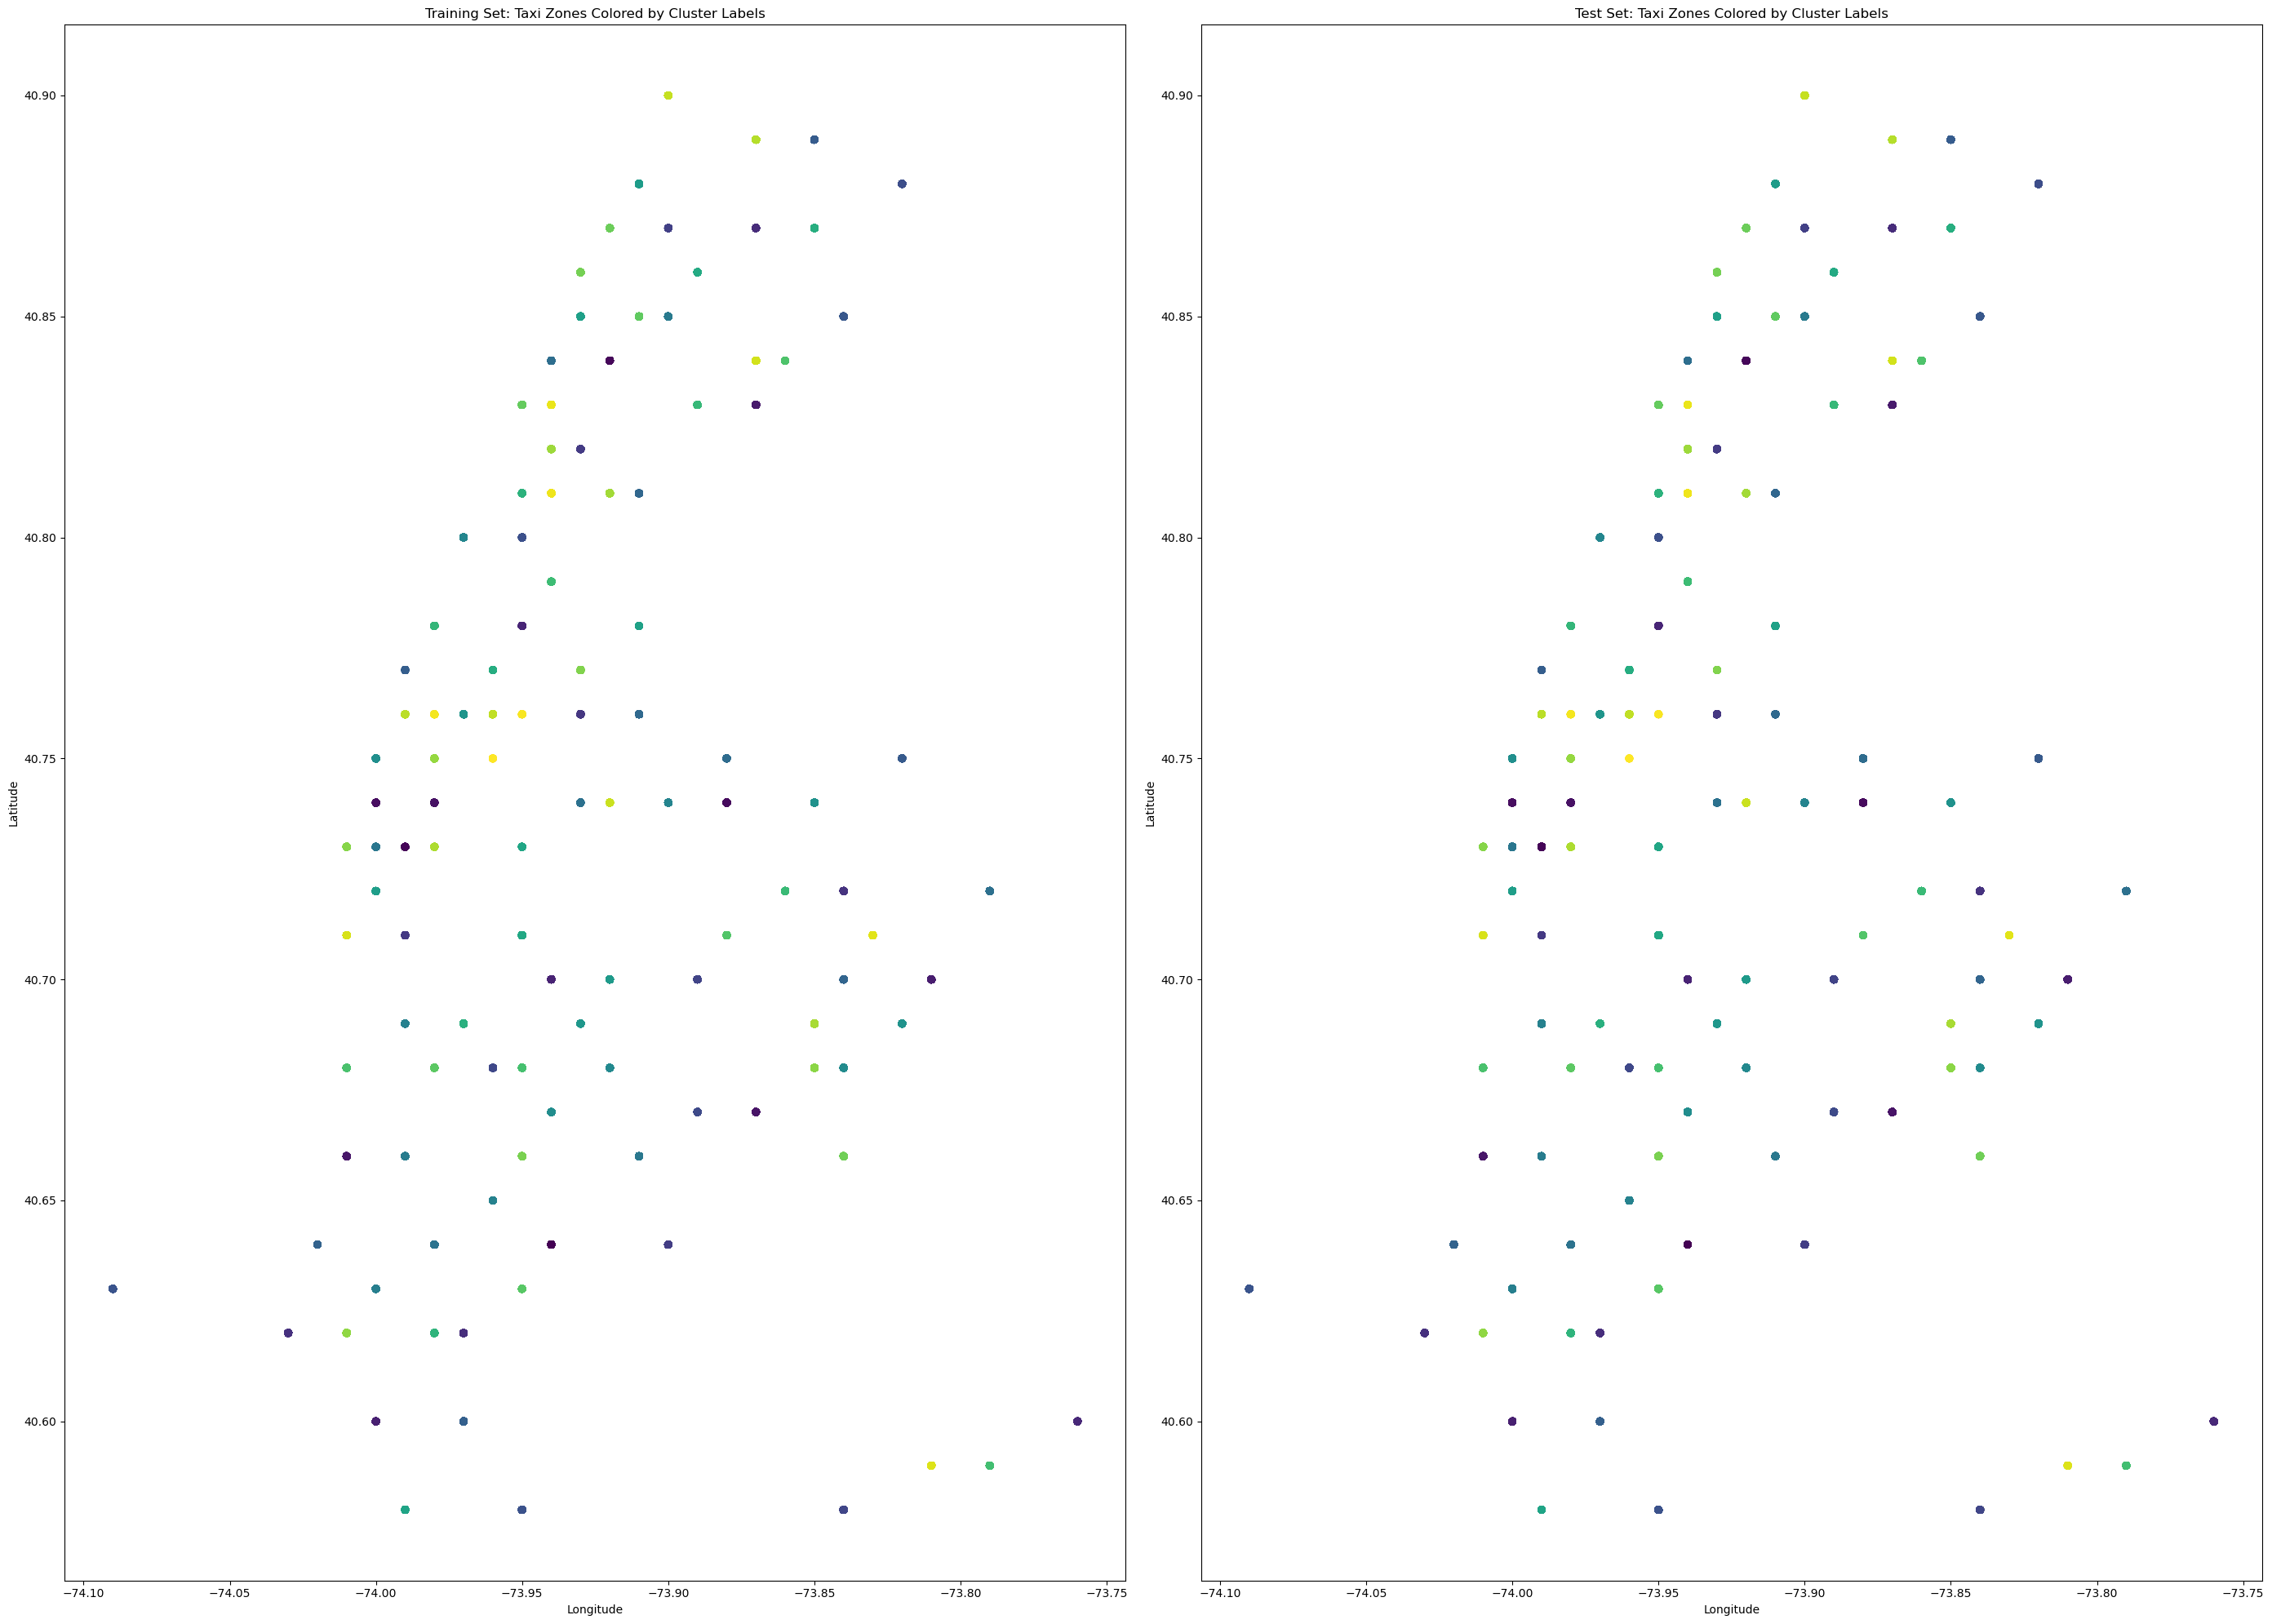

In [31]:
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
no_na.columns = no_na.columns.astype(str)

X_train, X_test = train_test_split(no_na, test_size=0.3, random_state=42)

kmeans = KMeans(n_clusters=116, random_state=0)
X_train['cluster'] = kmeans.fit_predict(X_train[['lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']])
centers = kmeans.cluster_centers_

X_test['cluster'] = kmeans.predict(X_test[['lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']])

silhouette_avg = silhouette_score(X_test[['lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']], X_test['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

plt.figure(figsize=(28, 20))

plt.subplot(1, 2, 1)
plt.scatter(X_train['lng'], X_train['lat'], c=X_train['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Set: Taxi Zones Colored by Cluster Labels')
plt.subplot(1, 2, 2)
plt.scatter(X_test['lng'], X_test['lat'], c=X_test['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Set: Taxi Zones Colored by Cluster Labels')

plt.tight_layout()
plt.show()

In [32]:
print(X_train['cluster'].value_counts())

cluster
23     2481
10     2386
36     2376
58     2242
29     2146
       ... 
108     189
80      171
113     107
114      60
115      22
Name: count, Length: 116, dtype: int64


Silhouette Score: 0.5193636889294185


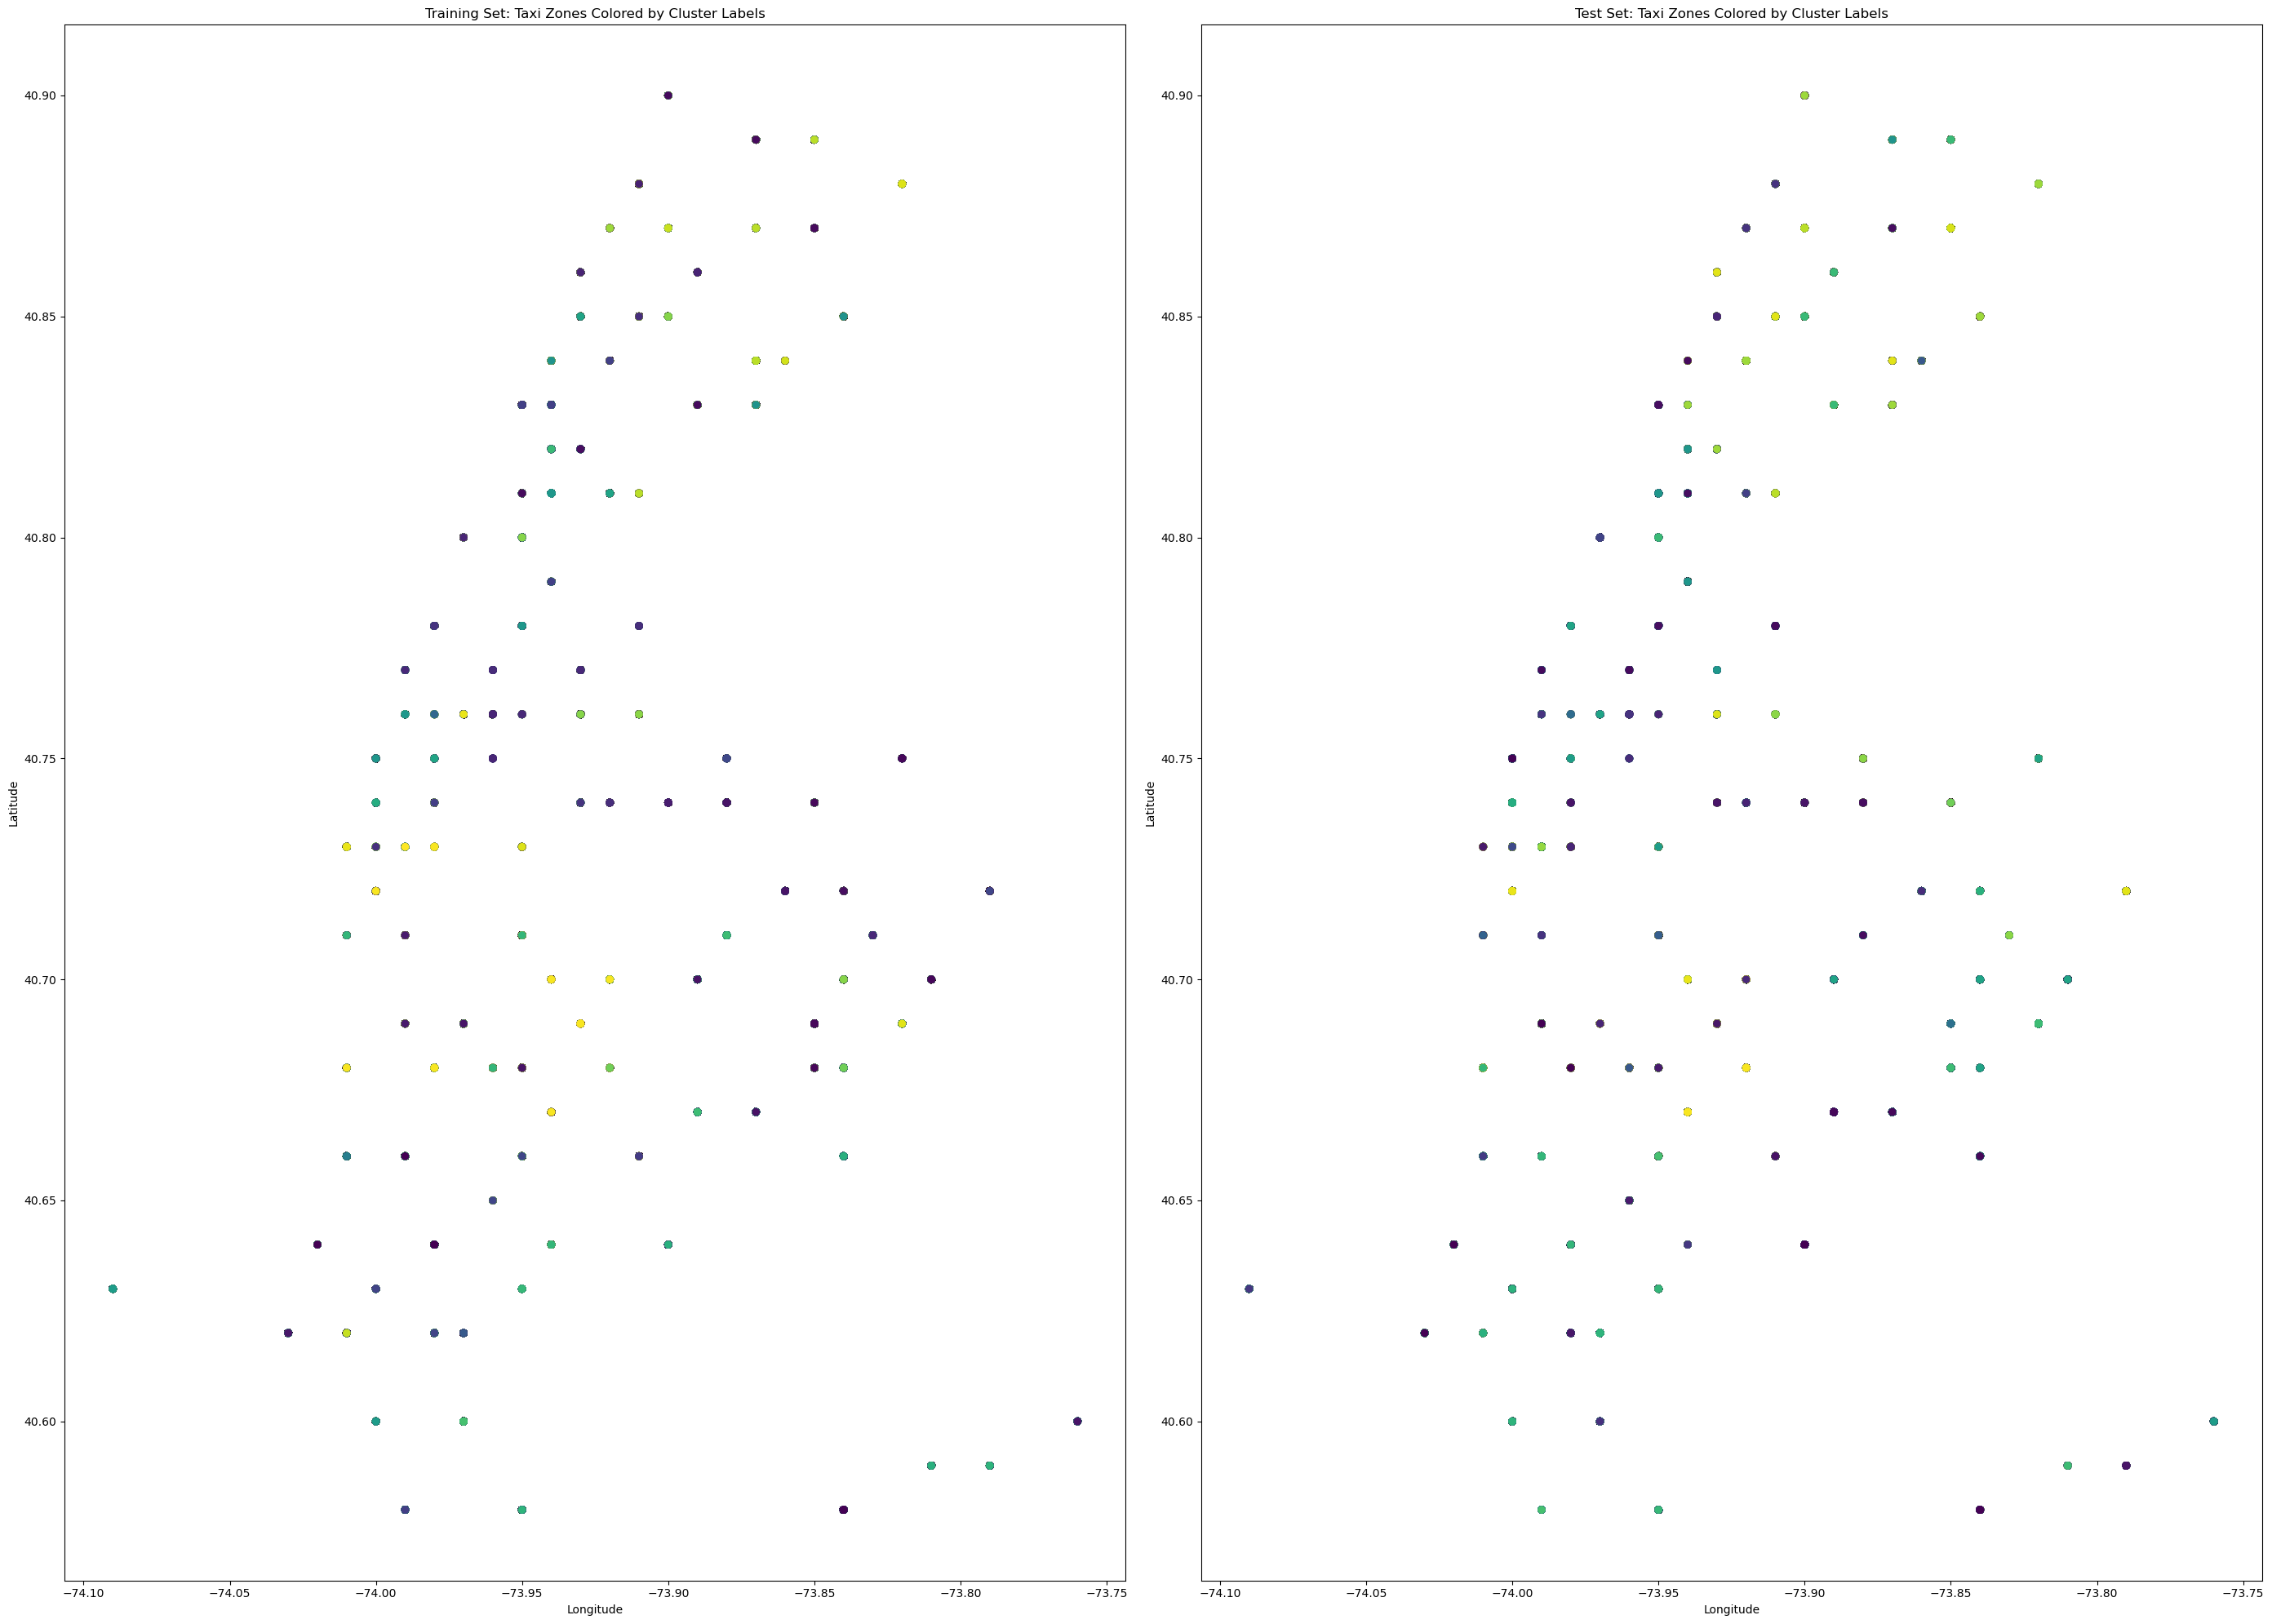

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib
no_na.columns = no_na.columns.astype(str)
tester = no_na.copy()
tester = tester[['Industry','lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']]
encoder = OneHotEncoder(sparse_output=False)
industry_encoded = encoder.fit_transform(tester[['Industry']])

industry_encoded_df = pd.DataFrame(industry_encoded, columns=encoder.get_feature_names_out(['Industry']))

no_na_encoded = pd.concat([tester.reset_index(drop=True), industry_encoded_df], axis=1).drop(columns=['Industry'])

X_train, X_test = train_test_split(no_na_encoded, test_size=0.3, random_state=42)

kmeans = KMeans(n_clusters=116, random_state=0)
X_train['cluster'] = kmeans.fit_predict(X_train.drop(columns=['cluster'], errors='ignore'))

X_test['cluster'] = kmeans.predict(X_test.drop(columns=['cluster'], errors='ignore'))

silhouette_avg = silhouette_score(X_test.drop(columns=['cluster']), X_test['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

plt.figure(figsize=(28, 20))

plt.subplot(1, 2, 1)
plt.scatter(X_train['lng'], X_train['lat'], c=X_train['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Set: Taxi Zones Colored by Cluster Labels')

plt.subplot(1, 2, 2)
plt.scatter(X_test['lng'], X_test['lat'], c=X_test['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Set: Taxi Zones Colored by Cluster Labels')

plt.tight_layout()
plt.show()


In [34]:
print(X_test['cluster'].value_counts())

cluster
67     2831
76     2507
0      2393
114    2243
103    2062
       ... 
91        8
102       5
113       5
112       4
99        3
Name: count, Length: 116, dtype: int64


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib
import numpy as np

no_na.columns = no_na.columns.astype(str)
tester = no_na.copy()

tester = tester.loc[:, ~tester.columns.duplicated()]
tester = tester[['Industry', 'zipcode', 'lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']]

encoder = OneHotEncoder(sparse_output=False)
industry_encoded = encoder.fit_transform(tester[['Industry']])
y_set = tester['zipcode']

industry_encoded_df = pd.DataFrame(industry_encoded, columns=encoder.get_feature_names_out(['Industry']))

no_na_encoded = pd.concat([tester.reset_index(drop=True), industry_encoded_df], axis=1).drop(columns=['Industry'])

X_train, X_test, y_train, y_test = train_test_split(no_na_encoded, y_set, test_size=0.33, random_state=42)

silhouette_scores = []
cluster_range = range(2, 30)  

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    X_train_clusters = kmeans.fit_predict(X_train.drop(columns=['zipcode', 'lng', 'lat']))
    X_test_clusters = kmeans.predict(X_test.drop(columns=['zipcode', 'lng', 'lat']))
    
    silhouette_avg = silhouette_score(X_test.drop(columns=['zipcode', 'lng', 'lat']), X_test_clusters)
    silhouette_scores.append(silhouette_avg)
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg}')

plt.figure(figsize=(12, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_n_clusters}')

kmeans = KMeans(n_clusters=best_n_clusters, random_state=0)
X_train_clusters = kmeans.fit_predict(X_train.drop(columns=['zipcode', 'lng', 'lat']))
X_train['cluster'] = X_train_clusters

X_test_clusters = kmeans.predict(X_test.drop(columns=['zipcode', 'lng', 'lat']))
X_test['cluster'] = X_test_clusters

def calculate_cluster_accuracy(y_true, clusters):
    cluster_to_label = {}
    for cluster in set(clusters):
        labels, counts = np.unique(y_true[clusters == cluster], return_counts=True)
        majority_label = labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
    
    predicted_labels = [cluster_to_label[cluster] for cluster in clusters]
    return accuracy_score(y_true, predicted_labels)

accuracy = calculate_cluster_accuracy(y_test.to_numpy(), X_test['cluster'])
print(f'Accuracy: {accuracy}')




Number of clusters: 2, Silhouette Score: 0.7605490287026146


KeyboardInterrupt: 

Silhouette Score: -0.3724298078126934
Accuracy: 0.0413102093805133


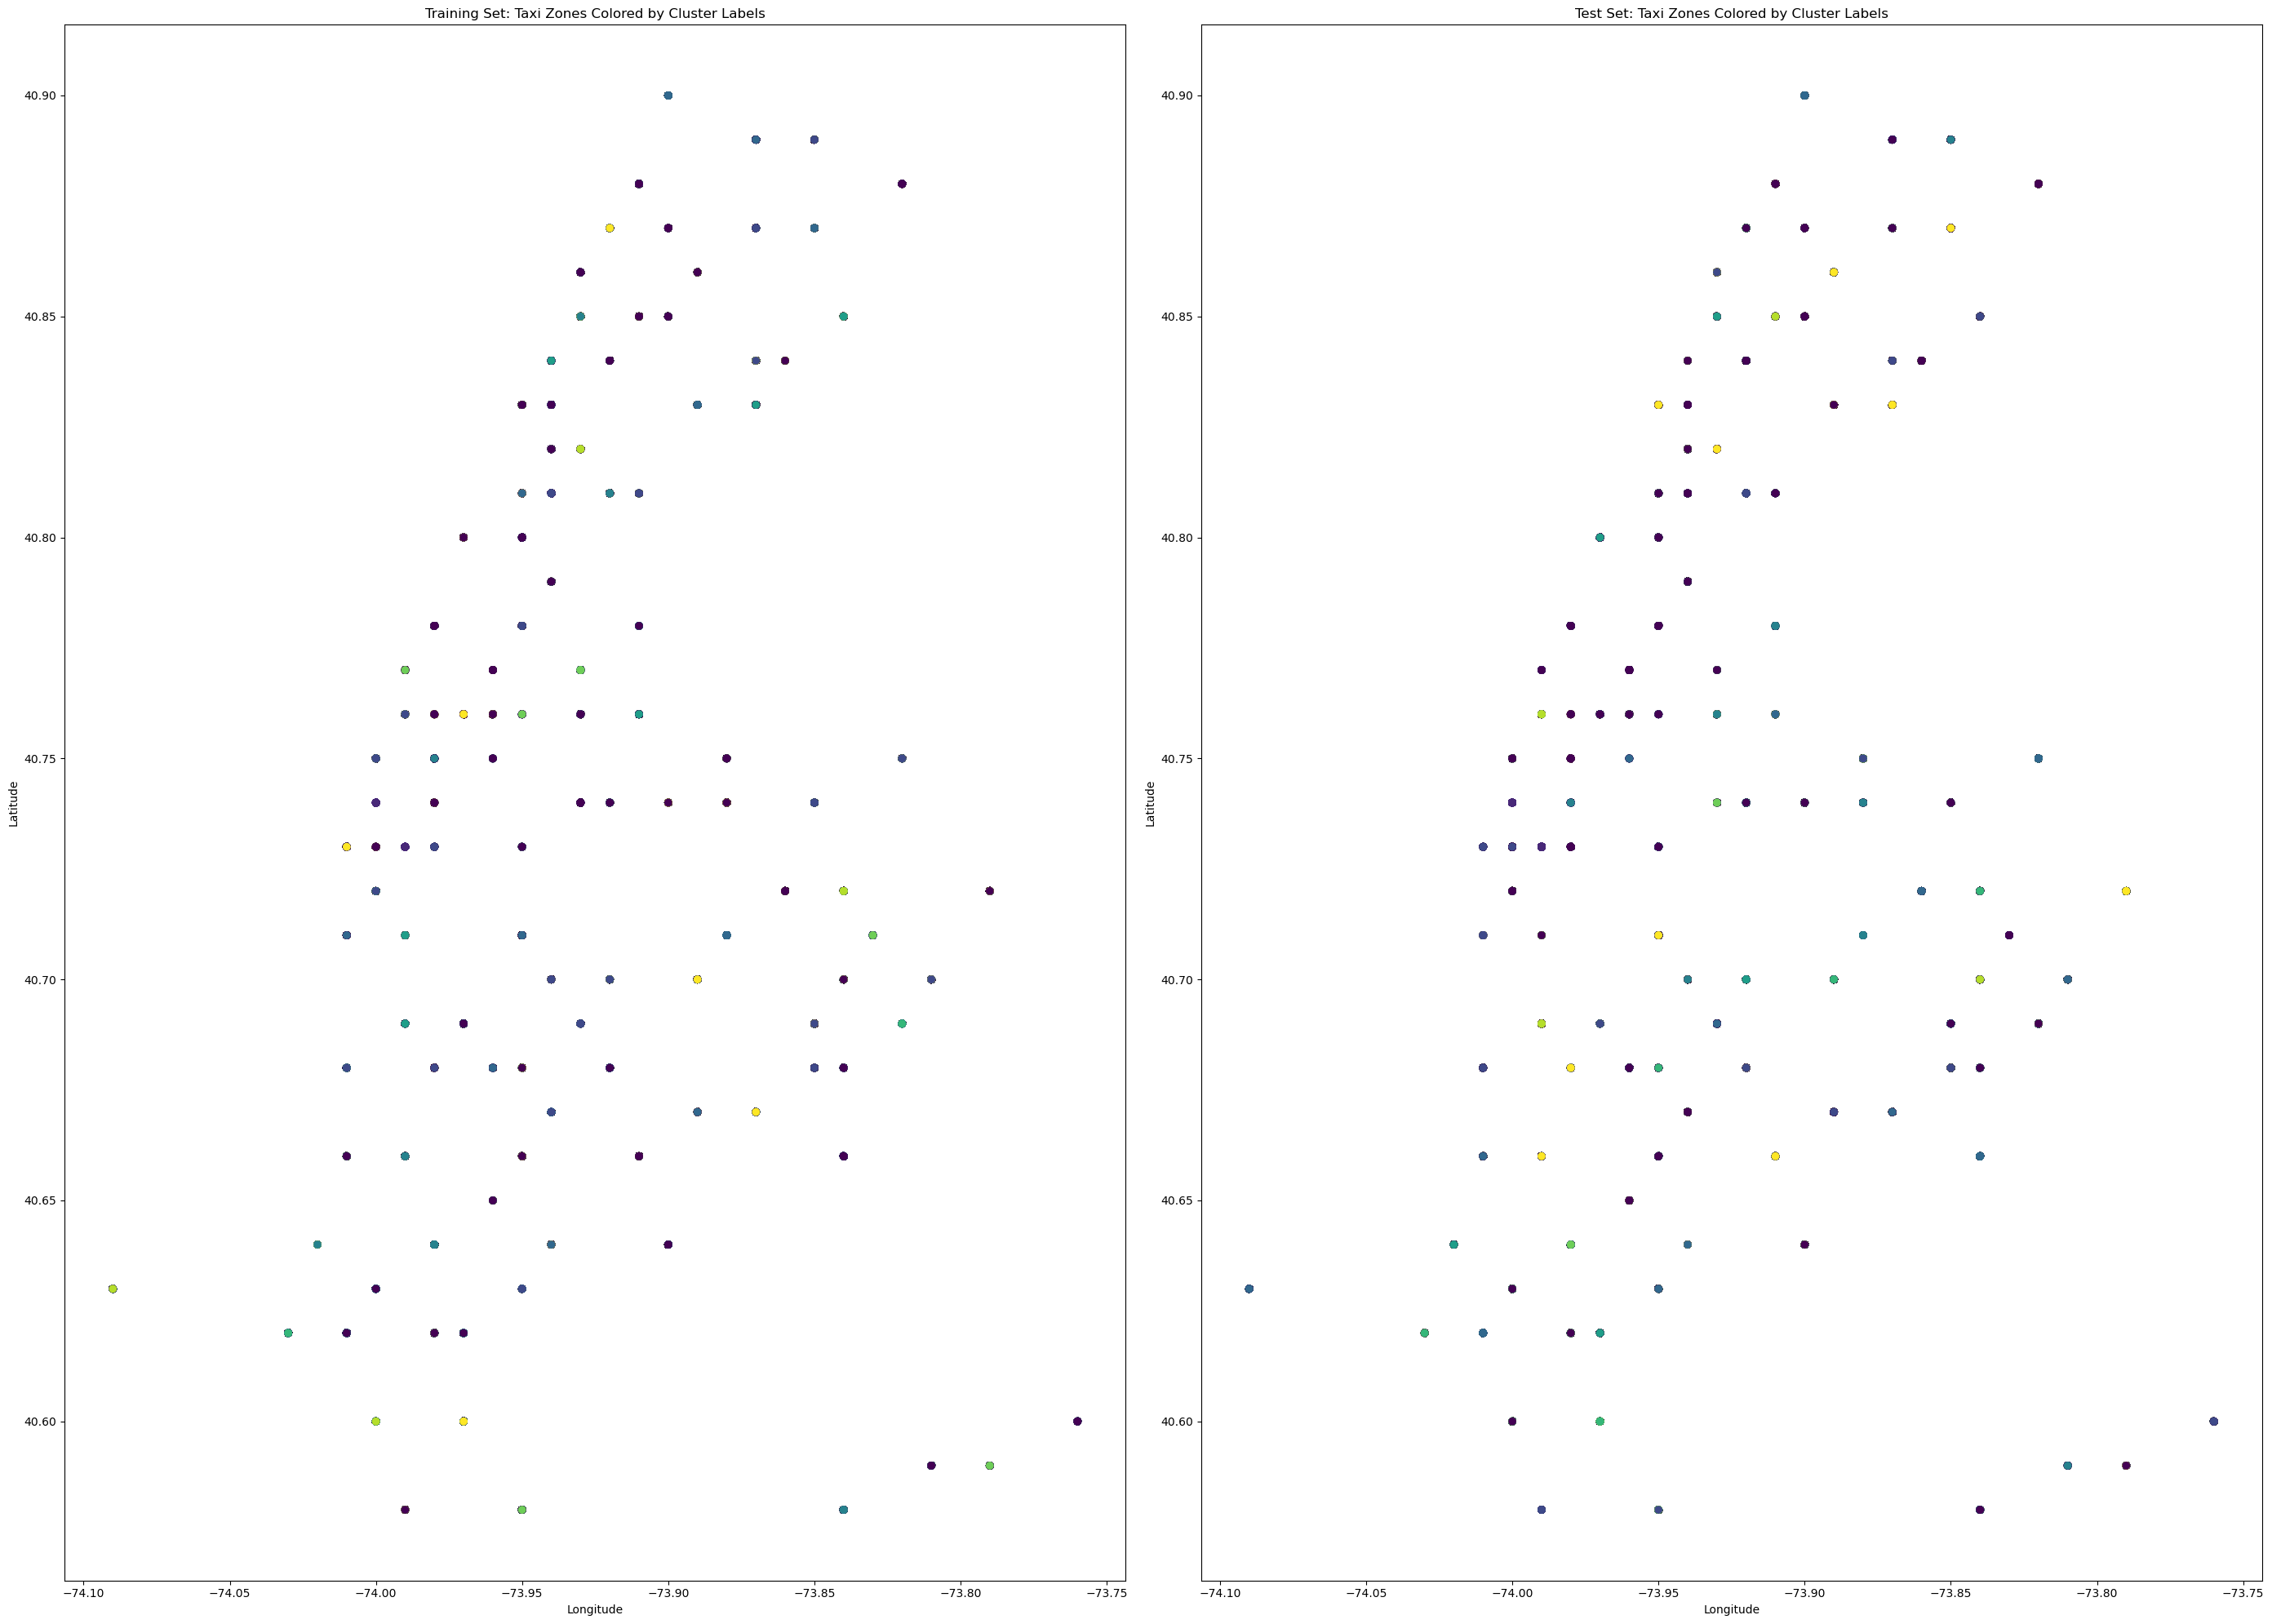

Model saved as dumb_idiot_model.pkl


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import joblib
import numpy as np

no_na.columns = no_na.columns.astype(str)
tester = no_na.copy()

tester = tester.loc[:, ~tester.columns.duplicated()]
tester = tester[['Industry', 'zipcode', 'lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']]

encoder = OneHotEncoder(sparse_output=False)
industry_encoded = encoder.fit_transform(tester[['Industry']])
y_set = tester['zipcode']

industry_encoded_df = pd.DataFrame(industry_encoded, columns=encoder.get_feature_names_out(['Industry']))

no_na_encoded = pd.concat([tester.reset_index(drop=True), industry_encoded_df], axis=1).drop(columns=['Industry'])

X_train, X_test, y_train, y_test = train_test_split(no_na_encoded, y_set, test_size=0.33, random_state=42)

kmeans = KMeans(n_clusters=10, random_state=0)
X_train_clusters = kmeans.fit_predict(X_train.drop(columns=['zipcode', 'lng', 'lat']))
X_train['cluster'] = X_train_clusters

X_test_clusters = kmeans.predict(X_test.drop(columns=['zipcode', 'lng', 'lat']))
X_test['cluster'] = X_test_clusters

silhouette_avg = silhouette_score(X_test.drop(columns=['cluster']), X_test['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

def calculate_cluster_accuracy(y_true, clusters):
    cluster_to_label = {}
    for cluster in set(clusters):
        labels, counts = np.unique(y_true[clusters == cluster], return_counts=True)
        majority_label = labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
    
    predicted_labels = [cluster_to_label[cluster] for cluster in clusters]
    return accuracy_score(y_true, predicted_labels)

accuracy = calculate_cluster_accuracy(y_test.to_numpy(), X_test['cluster'])
print(f'Accuracy: {accuracy}')

plt.figure(figsize=(28, 20))

plt.subplot(1, 2, 1)
plt.scatter(X_train['lng'], X_train['lat'], c=X_train['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Set: Taxi Zones Colored by Cluster Labels')

plt.subplot(1, 2, 2)
plt.scatter(X_test['lng'], X_test['lat'], c=X_test['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Set: Taxi Zones Colored by Cluster Labels')

plt.tight_layout()
plt.show()

model_filename = 'dumb_idiot_model.pkl'
joblib.dump(kmeans, model_filename)
print(f'Model saved as {model_filename}')


Silhouette Score: -0.3724298078126934
Accuracy: 0.0413102093805133


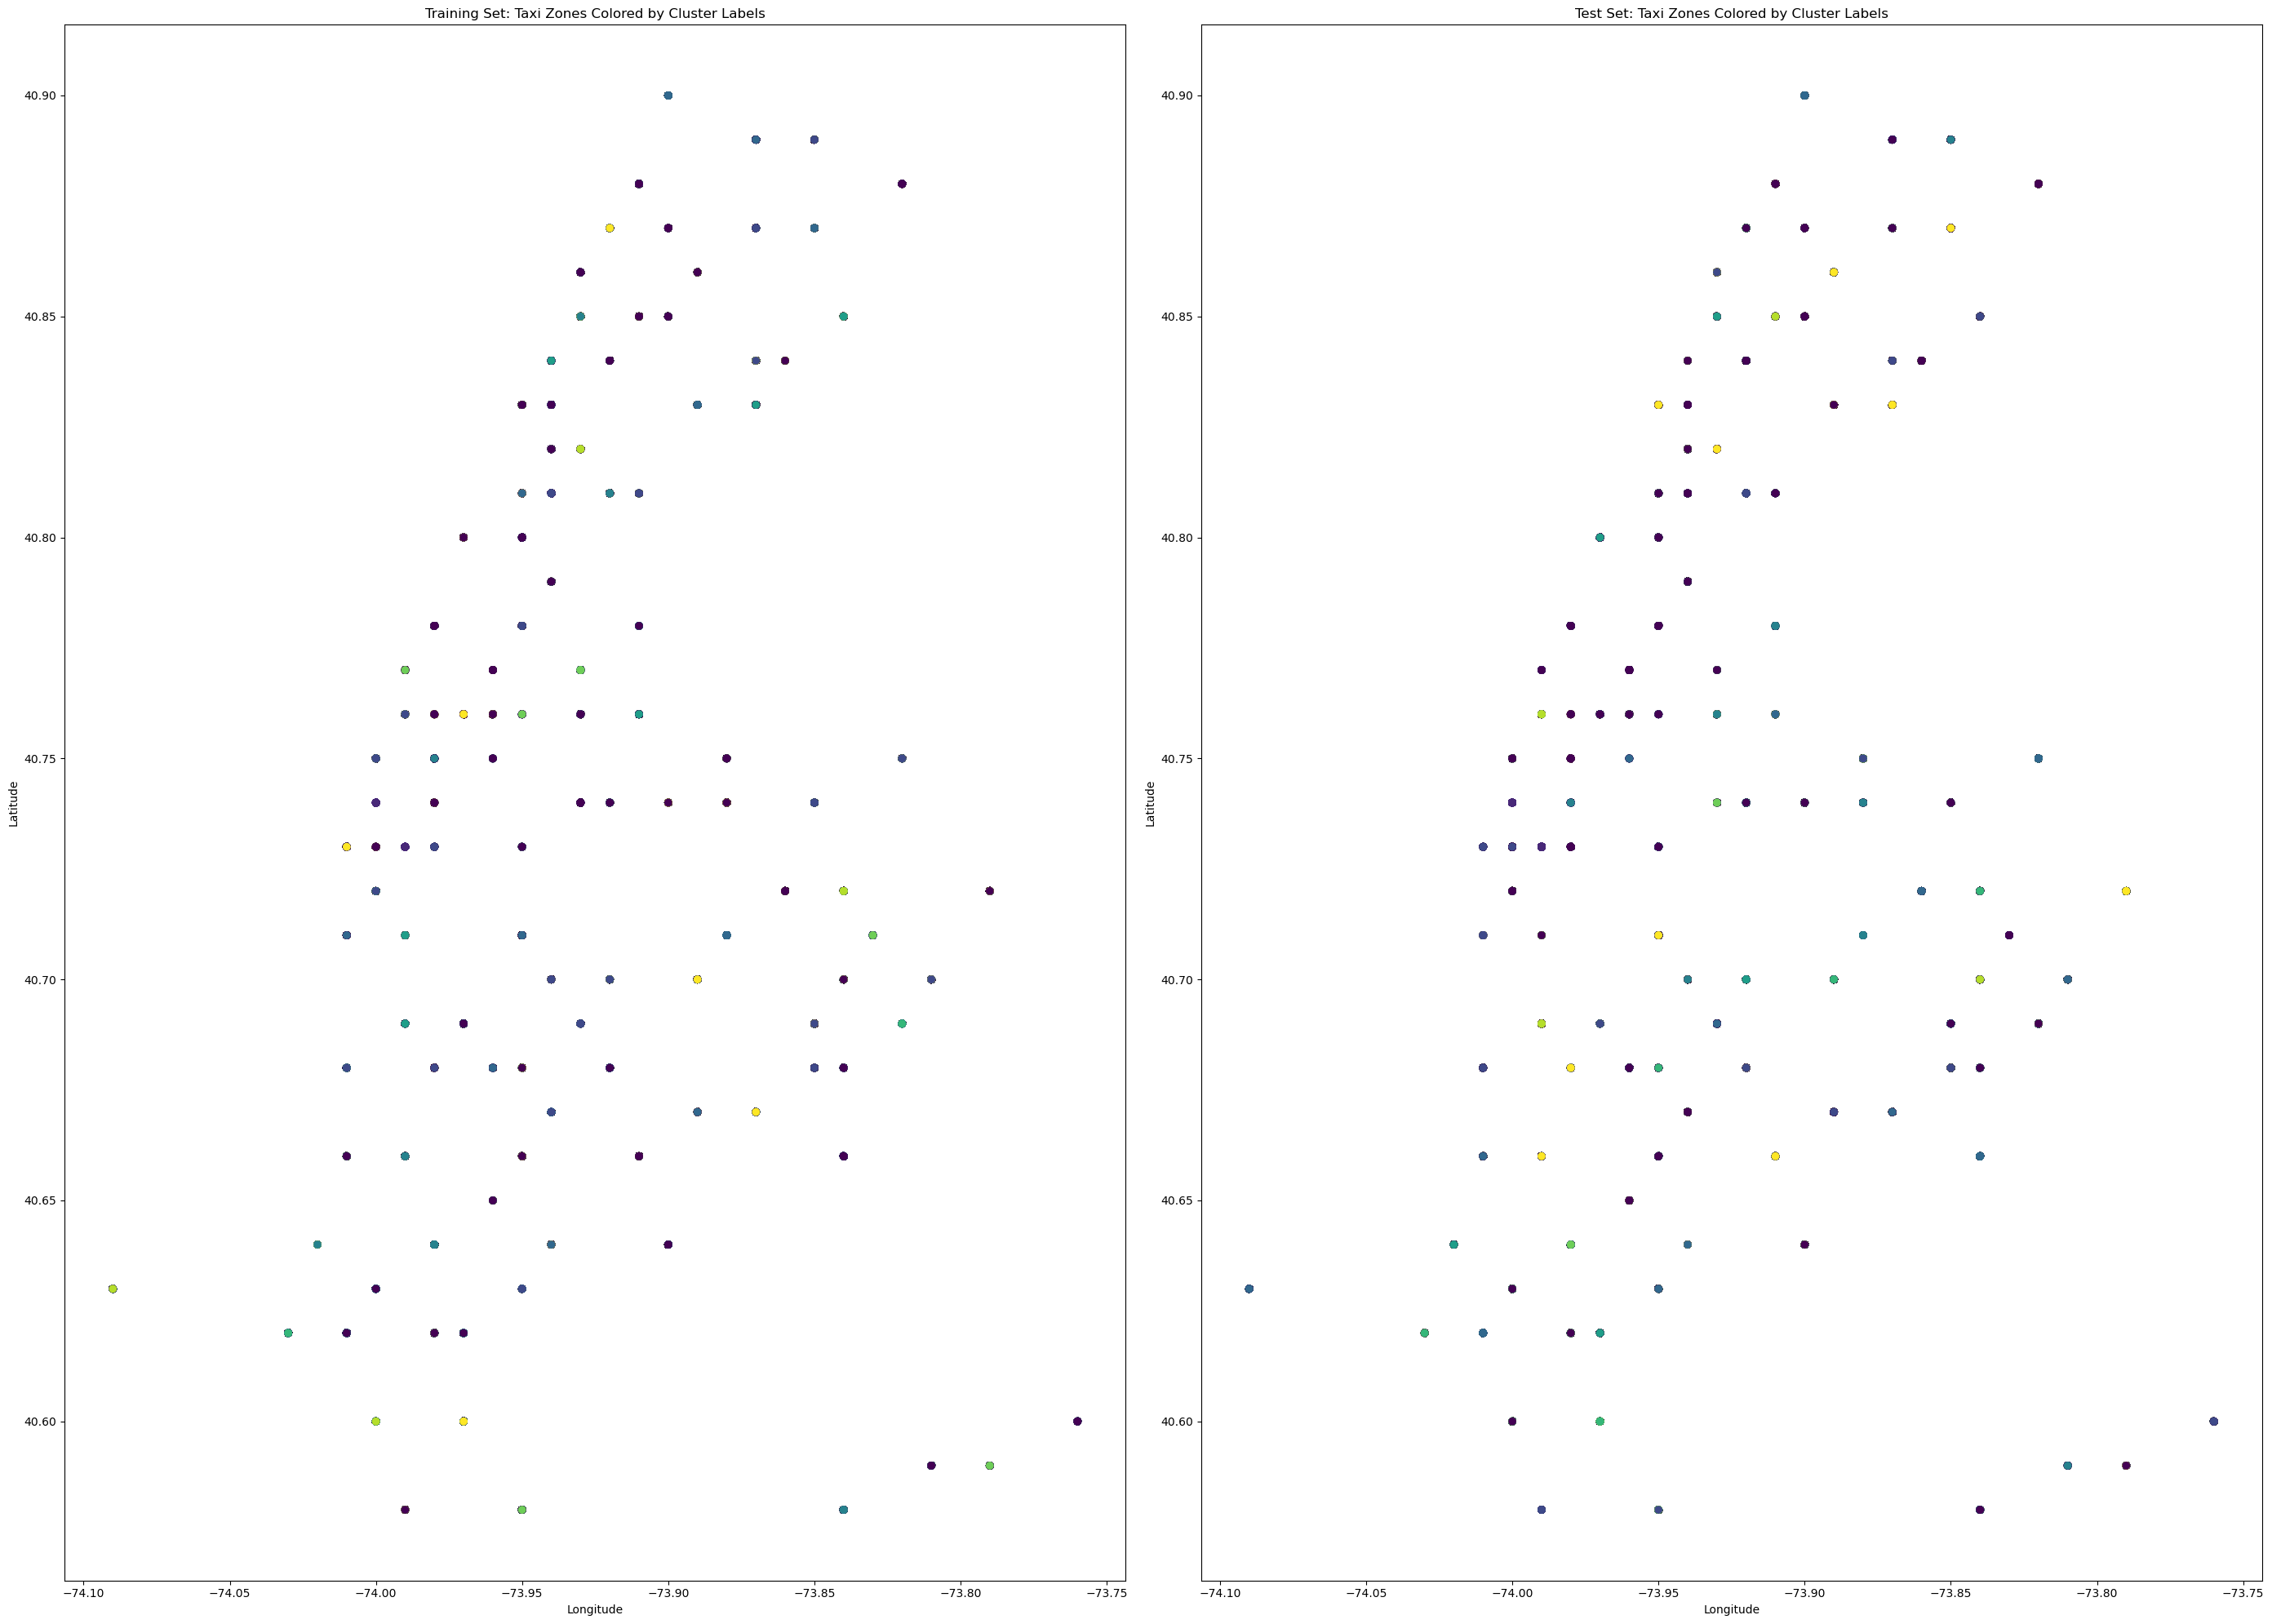

Model saved as dumb_idiot_model.pkl
        predicted_zipcode  actual_zipcode
41202             10019.0         10028.0
23626             10019.0         10013.0
81513             10019.0         11419.0
18842             10019.0         10019.0
30014             10019.0         11206.0
...                   ...             ...
159613            11368.0         10031.0
54548             10019.0         10468.0
109853            11218.0         11373.0
30311             10019.0         10023.0
823               11368.0         11215.0

[60082 rows x 2 columns]


In [38]:
# Assume no_na is already defined and cleaned as per the previous context
no_na.columns = no_na.columns.astype(str)
tester = no_na.copy()

tester = tester.loc[:, ~tester.columns.duplicated()]
tester = tester[['Industry', 'zipcode', 'lng', 'lat', 'hour 0', 'hour 1', 'hour 2', 'hour 3', 'hour 4', 'hour 5', 'hour 6', 'hour 7', 'hour 8', 'hour 9', 'hour 10', 'hour 11', 'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23']]

encoder = OneHotEncoder(sparse_output=False)
industry_encoded = encoder.fit_transform(tester[['Industry']])
y_set = tester['zipcode']

industry_encoded_df = pd.DataFrame(industry_encoded, columns=encoder.get_feature_names_out(['Industry']))

no_na_encoded = pd.concat([tester.reset_index(drop=True), industry_encoded_df], axis=1).drop(columns=['Industry'])

X_train, X_test, y_train, y_test = train_test_split(no_na_encoded, y_set, test_size=0.33, random_state=42)

kmeans = KMeans(n_clusters=10, random_state=0)
X_train_clusters = kmeans.fit_predict(X_train.drop(columns=['zipcode', 'lng', 'lat']))
X_train['cluster'] = X_train_clusters

X_test_clusters = kmeans.predict(X_test.drop(columns=['zipcode', 'lng', 'lat']))
X_test['cluster'] = X_test_clusters

silhouette_avg = silhouette_score(X_test.drop(columns=['cluster']), X_test['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

def calculate_cluster_accuracy(y_true, clusters):
    cluster_to_label = {}
    for cluster in set(clusters):
        labels, counts = np.unique(y_true[clusters == cluster], return_counts=True)
        majority_label = labels[np.argmax(counts)]
        cluster_to_label[cluster] = majority_label
    
    predicted_labels = [cluster_to_label[cluster] for cluster in clusters]
    return accuracy_score(y_true, predicted_labels)

accuracy = calculate_cluster_accuracy(y_test.to_numpy(), X_test['cluster'])
print(f'Accuracy: {accuracy}')

plt.figure(figsize=(28, 20))

plt.subplot(1, 2, 1)
plt.scatter(X_train['lng'], X_train['lat'], c=X_train['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Training Set: Taxi Zones Colored by Cluster Labels')

plt.subplot(1, 2, 2)
plt.scatter(X_test['lng'], X_test['lat'], c=X_test['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Test Set: Taxi Zones Colored by Cluster Labels')

plt.tight_layout()
plt.show()

model_filename = 'dumb_idiot_model.pkl'
joblib.dump(kmeans, model_filename)
print(f'Model saved as {model_filename}')

# Step to map clusters to most common zip code
cluster_to_zipcode = {}
for cluster in set(X_train_clusters):
    labels, counts = np.unique(y_train[X_train_clusters == cluster], return_counts=True)
    majority_label = labels[np.argmax(counts)]
    cluster_to_zipcode[cluster] = majority_label

# Predict zip codes for the test set
X_test['predicted_zipcode'] = X_test['cluster'].map(cluster_to_zipcode)

# Compare predicted zip codes with actual zip codes
comparison_df = X_test[['predicted_zipcode']].copy()
comparison_df['actual_zipcode'] = y_test.values

# Display the comparison

print(comparison_df)